In [2]:
%load_ext autoreload
%autoreload 2

import os, json
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from mpl_toolkits.mplot3d import axes3d, Axes3D
import scipy.io as spio
from scipy import stats
import pandas as pd

import ccf_analysis_utils

In [3]:
def get_region_tree(df, name):
    return df[df['region'] == name]['tree'].values[0]

def get_all_subregion_annotations_from_tree(df, tree):
    return df[df['tree'].str.contains(tree)]
              
def get_all_subregion_annotations_from_name(df, name):
    tree = get_region_tree(df, name)
    return get_all_subregion_annotations_from_tree(df, tree)

def get_n_layer_down_subregions_from_tree(df, tree, n):
    return df[df['tree'].str.contains(tree) & (df['tree'].str.count('/') == (tree.count('/')+n))]

def get_n_layer_down_subregions_from_name(df, name, n):
    tree = get_region_tree(df, name)
    return get_n_layer_down_subregions_from_tree(df, tree, n)

def sum_up_neurons(annotations_list, subregion_annotations):
    n = 0
    for subreg in subregion_annotations:
        n += np.sum(annotations_list == subreg)
    return n

def get_neuron_inds_for_subregions(annotations_list, subregion_annotations):
    inds = {}
    for subreg,subreg_annots in subregion_annotations.items():
        inds[subreg] = []
        for subreg_annot in subreg_annots:
            inds[subreg].append(np.where(annotations_list == subreg_annot)[0])
        inds[subreg] = np.concatenate(inds[subreg])
    return inds

def get_mean_and_sem_for_subregions(r2, inds, subregions):
    m = np.zeros(len(subregions))
    sem = np.zeros(len(subregions))
    for idx, sub_region_label in enumerate(subregions):
        m[idx] = np.mean(r2[inds[subregions[idx]]])
        sem[idx] = np.std(r2[inds[subregions[idx]]]) \
            /np.sqrt(r2[inds[subregions[idx]]].shape[0])
    return m, sem

def plot_barplot_with_sem(ax, m, sem, color_list, xticklabels,ylabel, n_neurons_list = None, highlight = None, rot = 90):
    
    ax.bar(np.arange(0,len(m)),m, color = color_list, \
           yerr=sem, align='center', ecolor='black', capsize=5)
    if highlight is not None:
        ax.bar(np.arange(0,len(m))[highlight],m[highlight], color = np.array(color_list)[highlight], \
              align='center', edgecolor='black', linewidth=2)
    
    _ = ax.set_xticks(np.arange(0,len(m)))
    _ = ax.set_xticklabels(xticklabels, rotation = rot)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    _ = ax.set_ylabel(ylabel)
    if n_neurons_list is not None:
        for i in range(len(n_neurons_list)):
            ax.text(i-0.3, m[i] + sem[i] + 0.3 * max(sem), 'n=%d' % n_neurons_list[i], fontsize=10, color='black')
    return ax

In [56]:
df = pd.read_excel('mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx',engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)

mat = spio.loadmat('forShaul.mat', squeeze_me = True)
simple_r2 = spio.loadmat('simple_r2.mat', squeeze_me = True)
r2 = simple_r2['simple_r2']
thalamus_mat = spio.loadmat('thalamus_subregions.mat', squeeze_me = True)

df.head()

,id,region,tree
0,997,root,/997/
1,8,Basic cell groups and regions,/997/8/
2,567,Cerebrum,/997/8/567/
3,688,Cerebral cortex,/997/8/567/688/
4,695,Cortical plate,/997/8/567/688/695/


In [57]:
Midbrain_subregions = get_n_layer_down_subregions_from_name(df, 'Midbrain', 1)['region'].values
Midbrain_subregions_annotations = {}
for subregion in Midbrain_subregions:
    Midbrain_subregions_annotations[subregion] = get_all_subregion_annotations_from_name(df, subregion)['region'].values
inds = get_neuron_inds_for_subregions(mat['annotation'], Midbrain_subregions_annotations)

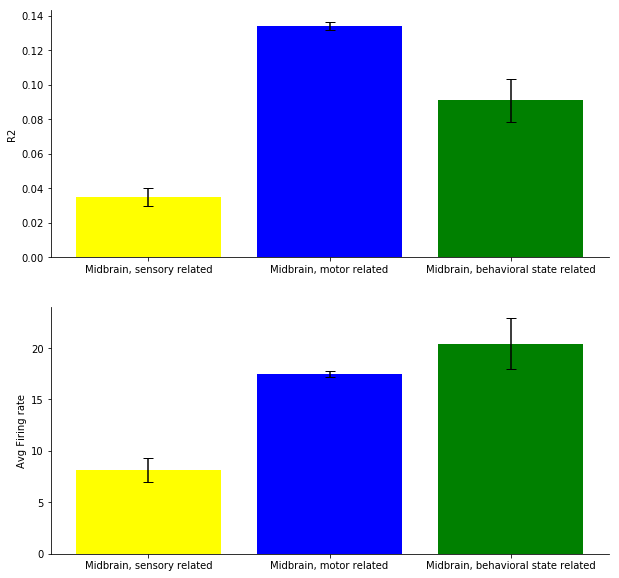

In [58]:
f = plt.figure(figsize=(10,10))
ax_bar = f.add_subplot(2,1,1)
cc = ['yellow','blue','green']
m, sem = get_mean_and_sem_for_subregions(r2, inds, Midbrain_subregions)
ax_bar = plot_barplot_with_sem(ax_bar, m, sem, cc, Midbrain_subregions, 'R2', rot = 0)

ax_bar = f.add_subplot(2,1,2)
m_fr, sem_fr = get_mean_and_sem_for_subregions(mat['fr'], inds, Midbrain_subregions)
ax_bar = plot_barplot_with_sem(ax_bar, m_fr, sem_fr, cc, Midbrain_subregions, 'Avg Firing rate', rot = 0)

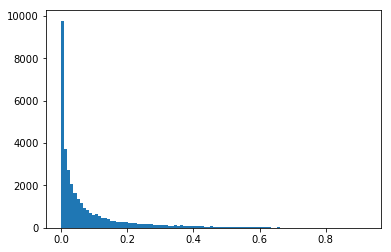

In [59]:
plt.hist(r2, bins = 100);

#### Try it with new data

In [60]:
import pickle
r2_new = pickle.load(open('r2_data_dict_clipped.pkl', 'rb'))

In [61]:
r2_new['5_0']

{'sample_r2': array([2.70402678e-04, 5.03942790e-02, 4.71204188e-01, ...,
        5.19108838e-02, 2.58913274e-02, 5.49034923e-04]),
 'delay_r2': array([2.47573369e-04, 6.72440372e-03, 1.70224043e-02, ...,
        2.72673798e-01, 2.48822035e-02, 5.60035007e-04]),
 'response_r2': array([8.46042326e-04, 2.11400346e-02, 8.07256236e-01, ...,
        8.75746674e-02, 1.72734026e-03, 5.90466914e-04]),
 'sample_r2_old': array([-0.01425744,  0.08221731, -0.03004296, ...,  0.00212246,
         0.05151172,  0.00425937]),
 'delay_r2_old': array([-0.01429784,  0.02381671, -0.01931326, ...,  0.00513344,
         0.03541739, -0.00262182]),
 'response_r2_old': array([-0.03283987,  0.06861501, -0.03668264, ..., -0.02393628,
         0.03761851,  0.10206267]),
 'session_name': array(['SC061_20210323_11', 'SC061_20210323_11', 'SC061_20210323_11', ...,
        'SC027_20190804_22', 'SC027_20190804_22', 'SC027_20190804_22'],
       dtype='<U17'),
 'ccf_coords': array([[4200, 3020, 3600],
        [4200, 3000,

(39890,)


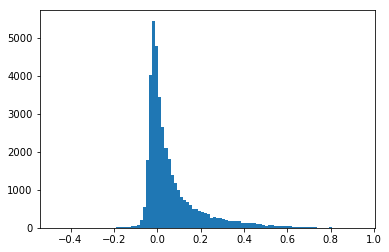

In [62]:
response_r2 = r2_new['5_0']['response_r2_old']
ccf_labels = r2_new['5_0']['ccf_labels']
response_fr = r2_new['5_0']['response_fr']
session_labels = r2_new['5_0']['session_name']
plt.hist(response_r2, bins = 100);
print(response_r2.shape)

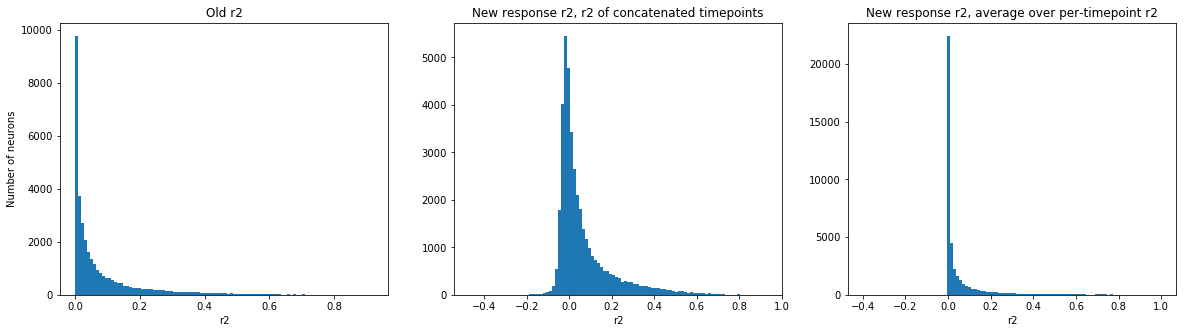

In [63]:
plt.subplots(1,3,figsize=(20,5))
plt.subplot(1,3,1)
plt.hist(r2, bins = 100);
plt.title('Old r2')
plt.ylabel('Number of neurons')
plt.xlabel('r2')

plt.subplot(1,3,2)
plt.hist(response_r2, bins = 100);
plt.title('New response r2, r2 of concatenated timepoints')
plt.xlabel('r2')

plt.subplot(1,3,3)
plt.hist(r2_new['5_0']['response_r2'], bins = np.linspace(-0.4,1,100));
plt.title('New response r2, average over per-timepoint r2')
plt.xlabel('r2')
plt.savefig('r2_distibution_comparison.png')

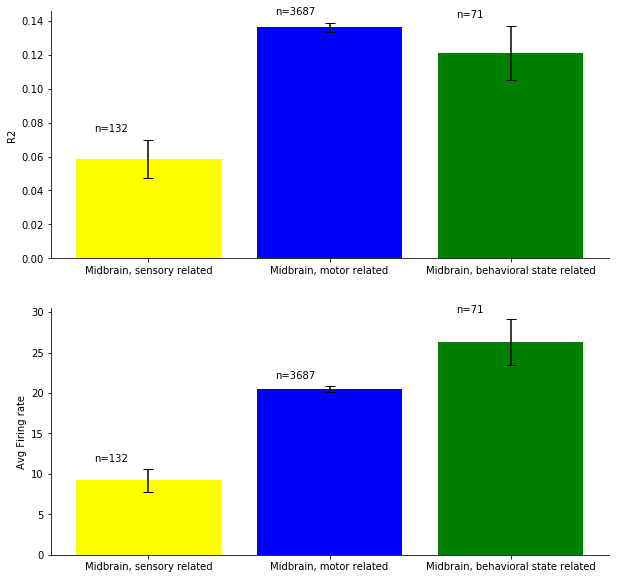

In [64]:
inds = get_neuron_inds_for_subregions(ccf_labels, Midbrain_subregions_annotations)
f = plt.figure(figsize=(10,10))
ax_bar = f.add_subplot(2,1,1)
cc = ['yellow','blue','green']
m, sem = get_mean_and_sem_for_subregions(response_r2, inds, Midbrain_subregions)
ax_bar = plot_barplot_with_sem(ax_bar, m, sem, cc, Midbrain_subregions, 'R2', rot = 0, n_neurons_list = [v.shape[0] for v in inds.values()])

ax_bar = f.add_subplot(2,1,2)
m_fr, sem_fr = get_mean_and_sem_for_subregions(response_fr, inds, Midbrain_subregions)
ax_bar = plot_barplot_with_sem(ax_bar, m_fr, sem_fr, cc, Midbrain_subregions, 'Avg Firing rate', rot = 0, n_neurons_list = [v.shape[0] for v in inds.values()])

Do some single animal comp.

In [65]:
animals = list(set([sess[:5] for sess in session_labels]))
animals

['SC053',
 'SC027',
 'SC045',
 'SC043',
 'SC065',
 'SC030',
 'SC060',
 'SC066',
 'SC064',
 'SC067',
 'SC061',
 'SC049',
 'SC032',
 'SC038',
 'SC031',
 'SC048',
 'SC033',
 'SC035',
 'SC026',
 'SC052',
 'SC050']

In [66]:
inds_for_animals = {}
for animal in animals:
    inds_for_animals[animal] = np.where([sess[:5] == animal for sess in session_labels])[0]

inds_for_animals

{'SC053': array([ 8850,  8851,  8852, ..., 36760, 36761, 36762]),
 'SC027': array([13021, 13022, 13023, ..., 39887, 39888, 39889]),
 'SC045': array([ 6189,  6190,  6191, ..., 37927, 37928, 37929]),
 'SC043': array([ 5505,  5506,  5507, ..., 37137, 37138, 37139]),
 'SC065': array([ 1125,  1126,  1127, ..., 39120, 39121, 39122]),
 'SC030': array([18950, 18951, 18952, ..., 23059, 23060, 23061]),
 'SC060': array([ 2622,  2623,  2624, ..., 20108, 20109, 20110]),
 'SC066': array([22275, 22276, 22277, ..., 39459, 39460, 39461]),
 'SC064': array([  492,   493,   494, ..., 37623, 37624, 37625]),
 'SC067': array([ 4490,  4491,  4492, ..., 31433, 31434, 31435]),
 'SC061': array([    0,     1,     2, ..., 35086, 35087, 35088]),
 'SC049': array([ 3015,  3016,  3017, ..., 31460, 31461, 31462]),
 'SC032': array([23062, 23063, 23064, 23065, 23066, 23067, 23068, 23069, 23070,
        23071, 23072, 23073, 23074, 23075, 23076, 23077, 23078, 23079,
        23080, 23081, 23082, 23083, 23084, 23085, 23086, 

SC053 2363
SC027 2510
SC045 1507
SC043 1628
SC065 2723
SC030 1047
SC060 1490
SC066 1871
SC064 3625
SC067 1988
SC061 1250
SC049 2226
SC032 930
SC038 2865
SC031 720
SC048 3587
SC033 484
SC035 1241
SC026 1050
SC052 1082
SC050 3703


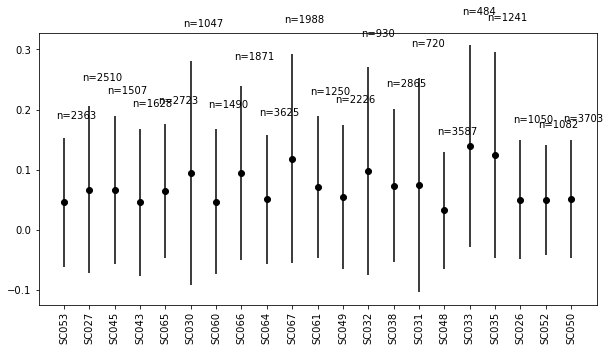

In [67]:
i= 0
ax, fig = plt.subplots(1,1,figsize=(10,5))
for k,v in inds_for_animals.items():
    print(k, v.shape[0])
    
    plt.errorbar([i],response_r2[v].mean(),yerr=response_r2[v].std(),color = 'k', fmt = 'o')
    plt.text(i-0.3, response_r2[v].mean() + response_r2[v].std() + 0.3 * np.max(response_r2[v].std()), 'n=%d'%v.shape[0], fontsize=10, color='black')
    i+=1

plt.xticks(np.arange(0,len(animals)), animals, rotation = 90);

In [68]:
Midbrain_subregions = get_n_layer_down_subregions_from_name(df, 'Midbrain', 0)['region'].values
Midbrain_subregions_annotations = {}
for subregion in Midbrain_subregions:
    Midbrain_subregions_annotations[subregion] = get_all_subregion_annotations_from_name(df, subregion)['region'].values
midbrain_inds = get_neuron_inds_for_subregions(ccf_labels, Midbrain_subregions_annotations)

In [69]:
midbrain_inds

{'Midbrain': array([ 726,  727,  735, ..., 4989, 4990, 4991])}

SC053 2363
SC027 2510
SC045 1507
SC043 1628
SC065 2723
SC030 1047
SC060 1490
SC066 1871
SC064 3625
SC067 1988
SC061 1250
SC049 2226
SC032 930
SC038 2865
SC031 720
SC048 3587
SC033 484
SC035 1241
SC026 1050
SC052 1082
SC050 3703


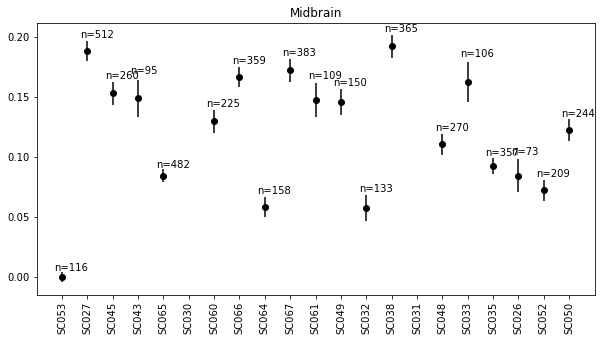

In [70]:
i= 0
ax, fig = plt.subplots(1,1,figsize=(10,5))
for k,v in inds_for_animals.items():
    print(k, v.shape[0])
    this_animal_inds = np.intersect1d(v,midbrain_inds['Midbrain'])
    if len(this_animal_inds) == 0:
        i+=1
        continue
    mean = response_r2[this_animal_inds].mean()
    std = response_r2[this_animal_inds].std()
    sem = std/np.sqrt(this_animal_inds.shape[0])
    plt.errorbar([i],mean,yerr=sem,color = 'k', fmt = 'o')
    plt.text(i-0.3,mean + sem + 0.3 * sem, 'n=%d'%this_animal_inds.shape[0], fontsize=10, color='black')
    i+=1

plt.title('Midbrain')
plt.xticks(np.arange(0,len(animals)), animals, rotation = 90);

In [73]:
np.sort(animals)

array(['SC026', 'SC027', 'SC030', 'SC031', 'SC032', 'SC033', 'SC035',
       'SC038', 'SC043', 'SC045', 'SC048', 'SC049', 'SC050', 'SC052',
       'SC053', 'SC060', 'SC061', 'SC064', 'SC065', 'SC066', 'SC067'],
      dtype='<U5')

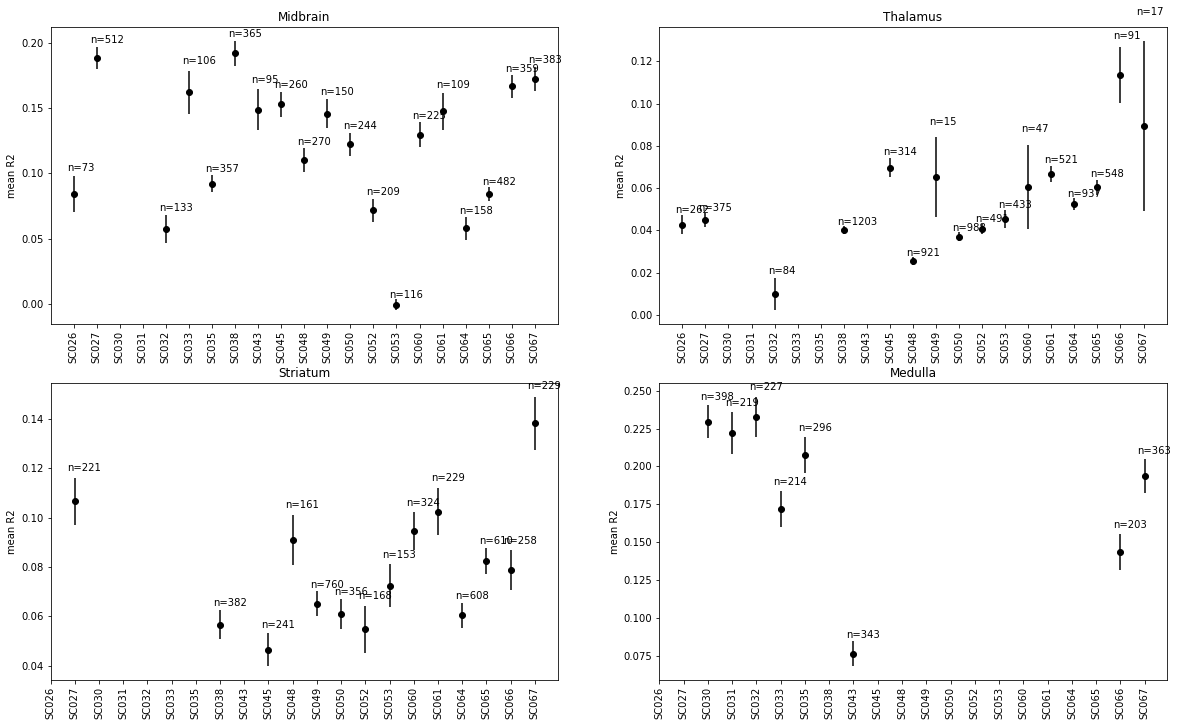

In [74]:
areas = ['Midbrain', 'Thalamus', 'Striatum', 'Medulla']

plt.subplots(2,2,figsize=(20,12))

for i, area in enumerate(areas):
    subregions = get_n_layer_down_subregions_from_name(df, area, 0)['region'].values
    subregions_annotations = {}
    for subregion in subregions:
        subregions_annotations[subregion] = get_all_subregion_annotations_from_name(df, subregion)['region'].values
    inds = get_neuron_inds_for_subregions(ccf_labels, subregions_annotations)

    plt.subplot(2,2,i+1)

    j= 0

    for k in np.sort(animals):
        v = inds_for_animals[k]
        this_animal_inds = np.intersect1d(v,inds[area])
        if len(this_animal_inds) == 0:
            j+=1
            continue
        mean = response_r2[this_animal_inds].mean()
        std = response_r2[this_animal_inds].std()
        sem = std/np.sqrt(this_animal_inds.shape[0])
        plt.errorbar([j],mean,yerr=sem,color = 'k', fmt = 'o')
        plt.text(j-0.3,mean + sem + 0.3 * sem, 'n=%d'%this_animal_inds.shape[0], fontsize=10, color='black')
        j+=1

    plt.title(area)
    plt.ylabel('mean R2')
    plt.xticks(np.arange(0,len(animals)), np.sort(animals), rotation = 90);

plt.savefig('single_animal_r2_by_area.png')
    

In [76]:
ttt = np.array([1,2,3,4,5,6,7,8,9,10])
ttt[range(0,len(ttt),2)]

array([1, 3, 5, 7, 9])

In [77]:
'%d'%-1

'-1'

In [16]:
[v.shape[0] for v in inds.values()]

{'Midbrain, sensory related': array([ 1208,  1684,  4753,  4754,  4766,  4767,  7526,  8890,  8891,
         8892,  9734,  9735, 12462, 12463, 12464, 12465, 12485, 12486,
        12489, 15707, 18583, 18584, 18596, 27978, 28463, 28476, 30320,
        35208, 37006, 37007, 37008, 37009, 37023, 37024,  4755,  4756,
         4768,  7527,  7528,  7529,  7538,  8893,  8898, 12466, 12467,
        12468, 15708, 15709, 15710, 17618, 17619, 17620, 17621, 18585,
        18586, 18587, 18597, 35460, 35461, 35466, 35712,  3911,  3912,
         3913,  7530,  7531, 17625, 23052, 35209, 12583, 12584, 12585,
        12586, 12587, 12588, 12589, 12575, 12576, 12577, 12578, 12579,
        12580, 12581, 12582, 19242, 19243, 19244, 19245, 19246, 19247,
        19248, 19249, 19250, 19251, 19252, 19253, 19254, 19255, 19256,
        19257, 19258, 19259, 19260, 19261, 19262, 19266, 19267, 19268,
        19269,  1582,  1585,  1586,  1587,  1588,  1589,  1590,  1591,
         1592,  1603,  1604,  1605,  1606,  1607

Now check what Nuo suggested.

In [6]:

Midbrain_motor_nuclei = [ # given by Nuo
    'Substantia nigra, reticular part',
    'Midbrain reticular nucleus',
    'Superior colliculus, motor related',
    'Periaqueductal gray',
    'Cuneiform nucleus',
    'Red nucleus',
]

Midbrain_behav_nuclei = [ # given by Nuo
    'Substantia nigra, compact part',
    'Pedunculopontine nucleus'
]

Midbrain_motor_nuclei_all = get_n_layer_down_subregions_from_name(df, 'Midbrain, motor related', 1)['region'].values
Midbrain_behav_nuclei_all = get_n_layer_down_subregions_from_name(df, 'Midbrain, behavioral state related', 1)['region'].values

Midbrain_motor_nuclei_annotations = {}
for subreg in Midbrain_motor_nuclei_all:
    Midbrain_motor_nuclei_annotations[subreg] = get_all_subregion_annotations_from_name(df, subreg)['region'].values

Midbrain_behav_nuclei_annotations = {}
for subreg in Midbrain_behav_nuclei_all:
    Midbrain_behav_nuclei_annotations[subreg] = get_all_subregion_annotations_from_name(df, subreg)['region'].values



In [7]:
motor_neuron_count = {}

for subreg, subreg_annots in Midbrain_motor_nuclei_annotations.items():
    motor_neuron_count[subreg] = sum_up_neurons(mat['annotation'], subreg_annots)

print('Motor:')
for k,v in motor_neuron_count.items():
    if k in Midbrain_motor_nuclei:
        print('*', k,v)
    else:
        print(k,v)

behav_neuron_count = {}

for subreg, subreg_annots in Midbrain_behav_nuclei_annotations.items():
    behav_neuron_count[subreg] = sum_up_neurons(mat['annotation'], subreg_annots)

print('Behavior:')
for k,v in behav_neuron_count.items():
    if k in Midbrain_behav_nuclei:
        print('*', k,v)
    else:
        print(k,v)

Motor:
* Substantia nigra, reticular part 250
Ventral tegmental area 22
Midbrain reticular nucleus, retrorubral area 25
* Midbrain reticular nucleus 1247
* Superior colliculus, motor related 1433
* Periaqueductal gray 3
Pretectal region 531
* Cuneiform nucleus 0
* Red nucleus 118
Oculomotor nucleus 0
Edinger-Westphal nucleus 0
Trochlear nucleus 0
Ventral tegmental nucleus 0
Anterior tegmental nucleus 0
Lateral terminal nucleus of the accessory optic tract 0
Dorsal terminal nucleus of the accessory optic tract 3
Medial terminal nucleus of the accessory optic tract 1
Substantia nigra, lateral part 0
Behavior:
* Substantia nigra, compact part 53
* Pedunculopontine nucleus 20
Midbrain raphe nuclei 0


In [8]:
motor_inds = get_neuron_inds_for_subregions(mat['annotation'], Midbrain_motor_nuclei_annotations)
behav_inds = get_neuron_inds_for_subregions(mat['annotation'], Midbrain_behav_nuclei_annotations)

joint_inds = {**motor_inds, **behav_inds}
joint_midbrain_nuclei = Midbrain_motor_nuclei + Midbrain_behav_nuclei

use_midbrain_nuclei = []
neuron_count = []
for k,v in joint_inds.items():
    if v.shape[0] > 0:
        use_midbrain_nuclei.append(k)
        neuron_count.append(v.shape[0])

In [9]:
num_motor = len(Midbrain_motor_nuclei_all)
num_behav = len(Midbrain_behav_nuclei_all)


cmap_motor = plt.cm.get_cmap('Blues', num_motor+3)
cmap_behav = plt.cm.get_cmap('Greens', num_behav+3)

joint_color_list = []
imotor = 0
ibehav = 0

for i in range(len(use_midbrain_nuclei)):
    if use_midbrain_nuclei[i] in Midbrain_motor_nuclei_all:
        joint_color_list.append(cmap_motor(imotor+3))
        imotor += 1
    elif use_midbrain_nuclei[i] in Midbrain_behav_nuclei_all:
        joint_color_list.append(cmap_behav(ibehav+3))
        ibehav += 1

highlight_mask = np.zeros(len(use_midbrain_nuclei), dtype=bool)
for i in range(len(use_midbrain_nuclei)):
    if use_midbrain_nuclei[i] in Midbrain_motor_nuclei:
        highlight_mask[i] = 1
    elif use_midbrain_nuclei[i] in Midbrain_behav_nuclei:
        highlight_mask[i] = 1

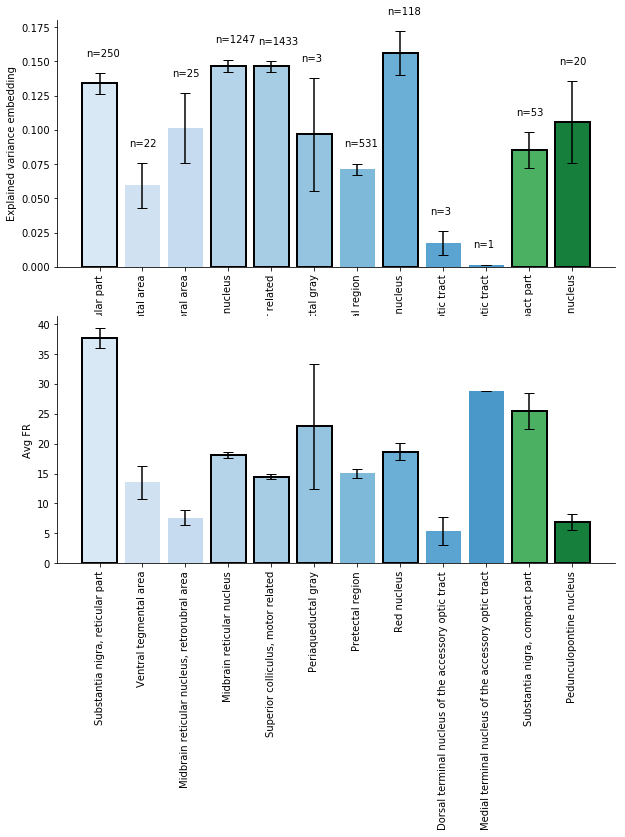

In [10]:
f = plt.figure(figsize=(10,10))
ax_bar = f.add_subplot(2,1,1)
m, sem = get_mean_and_sem_for_subregions(r2, joint_inds, use_midbrain_nuclei)
_ = plot_barplot_with_sem(ax_bar, m, sem, joint_color_list, use_midbrain_nuclei, 'Explained variance embedding', neuron_count, highlight_mask)


ax_bar = f.add_subplot(2,1,2)
m_fr, sem_fr = get_mean_and_sem_for_subregions(mat['fr'], joint_inds, use_midbrain_nuclei)
_ = plot_barplot_with_sem(ax_bar, m_fr, sem_fr, joint_color_list, use_midbrain_nuclei, 'Avg FR', highlight=highlight_mask)

plt.savefig('midbrain_subregions.pdf', bbox_inches='tight')

In [13]:
plot_dict = dict()
plot_dict['xlim'] = (-2000, 2000)
plot_dict['ylim'] = (2000,5500)
plot_dict['zlim'] = (2500,4500)
plot_dict['axis_zero_label'] = 'ML'
plot_dict['axis_one_label'] = 'DV'
plot_dict['axis_two_label'] = 'AP'

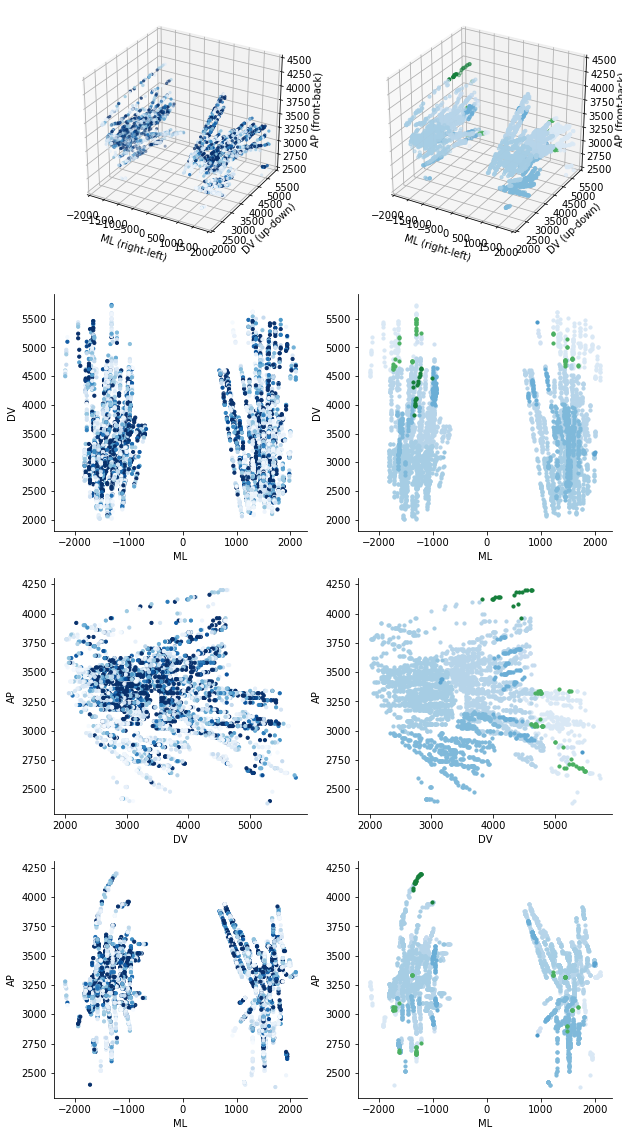

In [14]:
f = plt.figure(figsize=(10,20))
ax = f.add_subplot(4,2,1, projection='3d')
ccf_analysis_utils.add_color_map_plot(ax, use_midbrain_nuclei, joint_inds, r2, mat['coord'], \
                    0, (0.,0.2), True, plot_dict)

ax = f.add_subplot(4,2,2, projection='3d')
ccf_analysis_utils.add_solid_color_plot(ax, use_midbrain_nuclei, joint_inds, r2, \
                     mat['coord'], 0, \
                     joint_color_list, True, {**plot_dict})

ax = f.add_subplot(4,2,3)
three_d_flag = False
ccf_analysis_utils.add_color_map_plot(ax, use_midbrain_nuclei, joint_inds, r2, mat['coord'][:,0:2], \
                    0, (0.,0.2), three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'DV'})

ax = f.add_subplot(4,2,4)
ccf_analysis_utils.add_solid_color_plot(ax, use_midbrain_nuclei, joint_inds, r2, \
                        mat['coord'][:,0:2], 0, \
                        joint_color_list, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'DV'})

ax = f.add_subplot(4,2,5)
ccf_analysis_utils.add_color_map_plot(ax, use_midbrain_nuclei, joint_inds, r2, mat['coord'][:,1:], \
                    0, (0.,0.2), three_d_flag, {**plot_dict,'xlabel':'DV', 'ylabel':'AP'})

ax = f.add_subplot(4,2,6)
ccf_analysis_utils.add_solid_color_plot(ax, use_midbrain_nuclei, joint_inds, r2, \
                     mat['coord'][:,1:], 0, \
                     joint_color_list, three_d_flag, {**plot_dict,'xlabel':'DV', 'ylabel':'AP'})

ax = f.add_subplot(4,2,7)
ccf_analysis_utils.add_color_map_plot(ax, use_midbrain_nuclei, joint_inds, r2, mat['coord'][:,0::2], \
                    0, (0.,0.2), three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'AP'})

ax = f.add_subplot(4,2,8)
ccf_analysis_utils.add_solid_color_plot(ax, use_midbrain_nuclei, joint_inds, r2, \
                     mat['coord'][:,0::2], 0, \
                     joint_color_list, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'AP'})

plt.savefig('Midbrain_subregions_spatial_maps.pdf', bbox_inches='tight')